# Fine tuning a BERT model using a labeled Amazon Electronics review dataset

In this fine tuning, I used an already labeled dataset in Kaggle. https://www.kaggle.com/datasets/jimtsiobikas/amazon-reviews-2018-electronics 
This dataset contains the reviewText and all these texts are classified as POSITIVE, NEGATIVE or NEUTRAL.
This dataset have two csv files and here I use the 60k csv file.

In [ ]:
# Importing libraries and packages
import pandas as pd
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [4]:
# Loading dataset
test_df = pd.read_csv('/kaggle/input/amazon-reviews-2018-electronics/labeled_electronics_dataset_60k.csv')
test_df.head()

,overall,vote,verified,reviewTime,reviewText,summary,Label
0,5,0,True,2013-11-14,Have had this approx 6 months now - is much fa...,Great NAS Unit,POSITIVE
1,5,0,True,2013-04-23,I bought my first camera bag with my camera (a...,Great Bag,POSITIVE
2,4,0,True,2017-05-31,I use this case for a Panasonic Lumix ZS50 cam...,Decent Case for a Good Price -- With Some Caveats,POSITIVE
3,1,0,True,2014-11-25,Made no difference to my Sony camcorder.,One Star,NEGATIVE
4,5,0,True,2015-02-21,Raspbmc users will love this!,1424476800,POSITIVE


## Exploratory Analysis

In [5]:
test_df.shape

(60000, 7)

In [6]:
test_df['Label'].value_counts()

Label
POSITIVE    20000
NEGATIVE    20000
NEUTRAL     20000
Name: count, dtype: int64

## Data Preprocessing

In [7]:
# Extracting only the needed columns
cols = ['reviewText', 'Label']
df = test_df[cols]
df.head()

,reviewText,Label
0,Have had this approx 6 months now - is much fa...,POSITIVE
1,I bought my first camera bag with my camera (a...,POSITIVE
2,I use this case for a Panasonic Lumix ZS50 cam...,POSITIVE
3,Made no difference to my Sony camcorder.,NEGATIVE
4,Raspbmc users will love this!,POSITIVE


In [8]:
# Using only 1200 records from the dataset, containing 400 reviews from each sentiment
df_selected = df.groupby('Label', group_keys=False).apply(lambda x: x.sample(min(len(x), 400)))

/tmp/ipykernel_34/3158700188.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_selected = df.groupby('Label', group_keys=False).apply(lambda x: x.sample(min(len(x), 400)))


In [9]:
# Reset index to clean up the dataframe
df_selected = df_selected.reset_index(drop=True)

In [10]:
df_selected

,reviewText,Label
0,i am a professional cartoonist in the animatio...,NEGATIVE
1,Do not buy this drive!!!,NEGATIVE
2,"Instalation is tricky, and not always successful",NEGATIVE
3,Two Stars,NEGATIVE
4,Ordered this for my daughter for Christmas bec...,NEGATIVE
...,...,...
1195,NOTE: I bought this when it came out and cost ...,POSITIVE
1196,"This is a good mid tower case for the price, a...",POSITIVE
1197,"Works great, strong suction, very good battery...",POSITIVE
1198,Just got done installing this - I can say this...,POSITIVE


In [11]:
df_selected['Label'].value_counts()

Label
NEGATIVE    400
NEUTRAL     400
POSITIVE    400
Name: count, dtype: int64

In [12]:
# Converting NEGATIVE, NEUTRAL and POSITIVE labels to 0, 1 and 2 respectively.
df_selected['Label'] = df_selected['Label'].map({'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2})

## Fine-tuning BERT model 

### Model initialization

In [14]:
# Load the BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Train test split
X = list(df_selected['reviewText'])
y = list(df_selected['Label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
# Check for non-string elements in X_train
for i, text in enumerate(X_train):
    if not isinstance(text, str):
        print(f"Non-string element found at index {i}: {text}")

# Convert any non-string elements to strings (if applicable)
X_train = [str(text) for text in X_train]

# Tokenize the training data
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)

Non-string element found at index 578: nan


In [17]:
# Check for non-string elements in X_test
for i, text in enumerate(X_test):
    if not isinstance(text, str):
        print(f"Non-string element found at index {i}: {text}")

# Convert any non-string elements to strings (if applicable)
X_test = [str(text) for text in X_test]

# Tokenize the test data
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

In [18]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.encodings['input_ids'])

In [19]:
train_dataset = Dataset(X_train_tokenized, y_train)
test_dataset = Dataset(X_test_tokenized, y_test)

In [44]:
# Function to calculate performance 
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')
    
    return {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1
    }

In [21]:
# Define trainer
args = TrainingArguments(
    output_dir='output',
    num_train_epochs=1,
    per_device_train_batch_size=8,
 )
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

### Model training

In [46]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


TrainOutput(global_step=60, training_loss=0.7243691762288411, metrics={'train_runtime': 50.2675, 'train_samples_per_second': 19.098, 'train_steps_per_second': 1.194, 'total_flos': 252588881018880.0, 'train_loss': 0.7243691762288411, 'epoch': 1.0})

### Saving the fine tuned model

In [57]:
trainer.save_model('/kaggle/working/models/bert-finetuned')

In [48]:
eval_results = trainer.evaluate()
print(eval_results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [50]:
apple_df = pd.read_csv('/kaggle/input/amazon-apple-product-reviews/Apple_products.csv')
apple_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Five Stars,perfect,[],B00NQHZ2RU,B00NQHZ2RU,AGYCCDOVYOOUDZOETUJN4U5KAGIA,1486140013000,0,True
1,5.0,LOVE this iPhone 6,So far extremely happy with the iPhone 6. Thi...,[],B00NQGOZCY,B00NQGOZCY,AHGSUXT56Q3XVYD6J3YBZMBOCXHA,1495430457000,2,True
2,1.0,Malfunction a lot,I would not recommend buying any electronics f...,[],B07234GKN5,B07234GKN5,AFV4KKH356TLSZEHI3UBHN4SYSJQ,1582741702541,2,True
3,1.0,Battery is done for.,Battery is trashed essentially making the phon...,[],B07CQNF813,B07CQNF813,AFTPWGVZUDMJE5UUADHHZBQK4AIQ,1581536080691,0,True
4,5.0,Brand new phone,This is literally a brand new phone for a used...,[],B09JFN8K6T,B09JFN8K6T,AFBJCNQY5YUKIKOZT4OB2EQ7JWXA,1671675512431,3,True


In [51]:

# Assuming `unlabeled_texts` is a list of texts you want to predict
unlabeled_texts = apple_df['text'].tolist()

inputs = tokenizer(unlabeled_texts, padding=True, truncation=True, return_tensors="pt")

In [52]:
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    
    def __len__(self):
        return len(self.encodings['input_ids'])


In [53]:
unlabeled_dataset = UnlabeledDataset(inputs)

In [54]:
from torch.utils.data import DataLoader

unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=16, shuffle=False)

In [58]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('/kaggle/working/models/bert-finetuned')

# Tokenize inputs
inputs = tokenizer(unlabeled_texts, padding=True, truncation=True, return_tensors="pt")

# Determine the device (GPU if available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move the inputs to the device
inputs = {key: val.to(device) for key, val in inputs.items()}
model.to(device)

class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

unlabeled_dataset = UnlabeledDataset(inputs)

from torch.utils.data import DataLoader

unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=16, shuffle=False)

model.eval()

predictions = []
for batch in unlabeled_dataloader:
    with torch.no_grad():
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)
        predictions.extend(preds.cpu().numpy())

print(predictions)


[2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 0, 2, 1, 0, 2, 2, 2, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 0, 2, 2, 0, 1, 2, 2, 1, 0, 0, 1, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 1, 0, 2, 1, 0, 0, 2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 

In [59]:
apple_df['finetuned_bert_result'] = predictions

In [60]:
apple_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,finetuned_bert_result
0,5.0,Five Stars,perfect,[],B00NQHZ2RU,B00NQHZ2RU,AGYCCDOVYOOUDZOETUJN4U5KAGIA,1486140013000,0,True,2
1,5.0,LOVE this iPhone 6,So far extremely happy with the iPhone 6. Thi...,[],B00NQGOZCY,B00NQGOZCY,AHGSUXT56Q3XVYD6J3YBZMBOCXHA,1495430457000,2,True,2
2,1.0,Malfunction a lot,I would not recommend buying any electronics f...,[],B07234GKN5,B07234GKN5,AFV4KKH356TLSZEHI3UBHN4SYSJQ,1582741702541,2,True,0
3,1.0,Battery is done for.,Battery is trashed essentially making the phon...,[],B07CQNF813,B07CQNF813,AFTPWGVZUDMJE5UUADHHZBQK4AIQ,1581536080691,0,True,0
4,5.0,Brand new phone,This is literally a brand new phone for a used...,[],B09JFN8K6T,B09JFN8K6T,AFBJCNQY5YUKIKOZT4OB2EQ7JWXA,1671675512431,3,True,2


In [69]:
apple_df['rating'] = apple_df['rating'].map({5.0:2, 4.0:2, 3.0:1, 2.0:0, 1.0:0})

In [70]:
apple_df

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,finetuned_bert_result
0,2,Five Stars,perfect,[],B00NQHZ2RU,B00NQHZ2RU,AGYCCDOVYOOUDZOETUJN4U5KAGIA,1486140013000,0,True,2
1,2,LOVE this iPhone 6,So far extremely happy with the iPhone 6. Thi...,[],B00NQGOZCY,B00NQGOZCY,AHGSUXT56Q3XVYD6J3YBZMBOCXHA,1495430457000,2,True,2
2,0,Malfunction a lot,I would not recommend buying any electronics f...,[],B07234GKN5,B07234GKN5,AFV4KKH356TLSZEHI3UBHN4SYSJQ,1582741702541,2,True,0
3,0,Battery is done for.,Battery is trashed essentially making the phon...,[],B07CQNF813,B07CQNF813,AFTPWGVZUDMJE5UUADHHZBQK4AIQ,1581536080691,0,True,0
4,2,Brand new phone,This is literally a brand new phone for a used...,[],B09JFN8K6T,B09JFN8K6T,AFBJCNQY5YUKIKOZT4OB2EQ7JWXA,1671675512431,3,True,2
...,...,...,...,...,...,...,...,...,...,...,...
557,2,So far so good!,Phone was delivered ahead of schedule in a nic...,[],B07234GKN5,B07234GKN5,AG5PUKOPK44RN3AOBIKHZKBWF37Q,1547241048498,3,True,2
558,0,I need a refund or new phone please contact me!!!,The camera is very shaky when trying to take a...,[],B07234GKN5,B07234GKN5,AGXRAITRVQW7QS7EKOVLWK3LXNIA,1572410517164,2,True,0
559,0,It doesnt work!,I bought this an a month after I bought it it ...,[],B07234GKN5,B07234GKN5,AFCVQHOKT3O54IOHSS24XEFQHXMA,1572935042786,3,True,0
560,2,Good supplier,Product worked as expected,[],B07759SBP7,B07759SBP7,AH6OJZQU5RIK55HIDN2WUHNY6ZCA,1557508195982,0,True,2


In [71]:
import seaborn as sns

cols = ['rating','finetuned_bert_result']
df_rates = apple_df[cols]
df_rates

,rating,finetuned_bert_result
0,2,2
1,2,2
2,0,0
3,0,0
4,2,2
...,...,...
557,2,2
558,0,0
559,0,0
560,2,2


NameError: name 'plot' is not defined

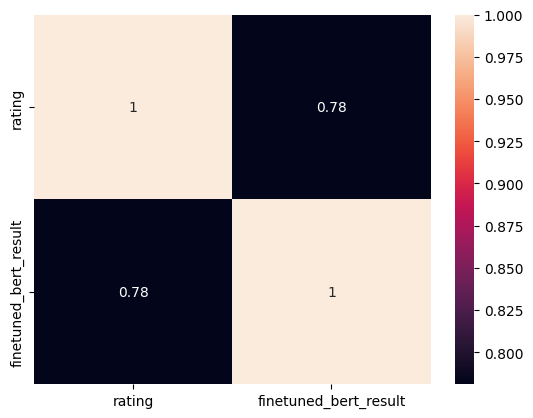

In [72]:
sns.heatmap(df_rates.corr(),annot=True)
plot.show()

In [73]:
results_df = pd.read_csv('/kaggle/input/pretrained-without-finetuning/apple_processed_with_pretrained_models.csv')

In [74]:
results_df

,Unnamed: 0,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,Method1_result,Method2_result
0,0,5,Five Stars,perfect,[],B00NQHZ2RU,B00NQHZ2RU,AGYCCDOVYOOUDZOETUJN4U5KAGIA,1486140013000,0,True,0.999852,5
1,1,5,LOVE this iPhone 6,So far extremely happy with the iPhone 6. Thi...,[],B00NQGOZCY,B00NQGOZCY,AHGSUXT56Q3XVYD6J3YBZMBOCXHA,1495430457000,2,True,0.999749,5
2,2,1,Malfunction a lot,I would not recommend buying any electronics f...,[],B07234GKN5,B07234GKN5,AFV4KKH356TLSZEHI3UBHN4SYSJQ,1582741702541,2,True,-0.997918,1
3,3,1,Battery is done for.,Battery is trashed essentially making the phon...,[],B07CQNF813,B07CQNF813,AFTPWGVZUDMJE5UUADHHZBQK4AIQ,1581536080691,0,True,-0.999787,1
4,4,5,Brand new phone,This is literally a brand new phone for a used...,[],B09JFN8K6T,B09JFN8K6T,AFBJCNQY5YUKIKOZT4OB2EQ7JWXA,1671675512431,3,True,0.997267,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,557,5,So far so good!,Phone was delivered ahead of schedule in a nic...,[],B07234GKN5,B07234GKN5,AG5PUKOPK44RN3AOBIKHZKBWF37Q,1547241048498,3,True,-0.991101,4
558,558,2,I need a refund or new phone please contact me!!!,The camera is very shaky when trying to take a...,[],B07234GKN5,B07234GKN5,AGXRAITRVQW7QS7EKOVLWK3LXNIA,1572410517164,2,True,-0.999763,2
559,559,1,It doesnt work!,I bought this an a month after I bought it it ...,[],B07234GKN5,B07234GKN5,AFCVQHOKT3O54IOHSS24XEFQHXMA,1572935042786,3,True,-0.999617,1
560,560,5,Good supplier,Product worked as expected,[],B07759SBP7,B07759SBP7,AH6OJZQU5RIK55HIDN2WUHNY6ZCA,1557508195982,0,True,0.980503,4


In [75]:
df_rates['bert_result'] = results_df['Method2_result']
df_rates

/tmp/ipykernel_34/4052777622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rates['bert_result'] = results_df['Method2_result']


,rating,finetuned_bert_result,bert_result
0,2,2,5
1,2,2,5
2,0,0,1
3,0,0,1
4,2,2,5
...,...,...,...
557,2,2,4
558,0,0,2
559,0,0,1
560,2,2,4


In [76]:
df_rates['bert_result'] = df_rates['bert_result'].map({5:2, 4:2, 3:1, 2:0, 1:0})

/tmp/ipykernel_34/2527369536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rates['bert_result'] = df_rates['bert_result'].map({5:2, 4:2, 3:1, 2:0, 1:0})


In [77]:
df_rates

,rating,finetuned_bert_result,bert_result
0,2,2,2
1,2,2,2
2,0,0,0
3,0,0,0
4,2,2,2
...,...,...,...
557,2,2,2
558,0,0,0
559,0,0,0
560,2,2,2


<Axes: >

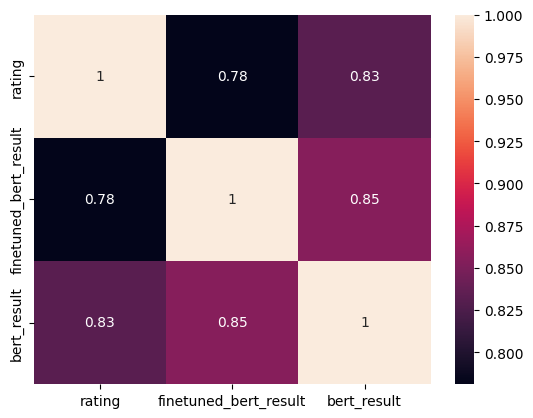

In [78]:
sns.heatmap(df_rates.corr(),annot=True)

In [79]:
y_test

[0,
 2,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 1,
 1,
 1,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 0,
 0,
 1,
 2,
 1,
 0]